In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
df = pd.read_csv('modis_2022_Colombia.csv')

columns_to_drop = ['version', 'scan', 'track', 'satellite', 'daynight']
df = df.drop(columns_to_drop, axis=1)

df.dropna()
df['datetime'] = pd.to_datetime(df['acq_date'] + ' ' + df['acq_time'].astype(str), format='%Y-%m-%d %H%M')

In [4]:
df.tail()

,latitude,longitude,brightness,acq_date,acq_time,instrument,confidence,bright_t31,frp,type,datetime
30241,2.7619,-72.0371,322.6,2022-12-31,1908,MODIS,77,293.6,97.7,0,2022-12-31 19:08:00
30242,2.7699,-72.0057,316.9,2022-12-31,1908,MODIS,51,293.6,62.0,0,2022-12-31 19:08:00
30243,4.1419,-71.7690,333.6,2022-12-31,1909,MODIS,74,292.4,235.6,0,2022-12-31 19:09:00
30244,4.1261,-71.7749,320.5,2022-12-31,1909,MODIS,50,289.9,101.5,0,2022-12-31 19:09:00
30245,4.1436,-71.7770,334.4,2022-12-31,1909,MODIS,81,291.9,246.4,0,2022-12-31 19:09:00


In [5]:
df_temperature = pd.read_csv('colombia_2022-01-01_2022-12-31.csv', sep=';', decimal=',',nrows = 1000)
df_temperature.rename(columns={'Lon': 'longitude', 'Lat': 'latitude'}, inplace=True)
df_temperature.dropna()
df_temperature['datetime'] = pd.to_datetime(df_temperature['Fecha (UTC-5)'], format='%Y-%m-%d %H:%M')

In [6]:
df_temperature.head()

,Fecha (UTC-5),latitude,longitude,Fuente,Temperatura (C),Temperatura Alt* (C),Radiación térmica (MW),Confianza,Captura (Dia-Noche),Scan - real pixel size (km),Track - real pixel size (km),datetime
0,2022-01-01 00:50,11.06089,-72.75468,VIIRS-Suomi-NPP,32.8,18.2,1.7,Nominal,N,0.62,0.54,2022-01-01 00:50:00
1,2022-01-01 00:50,11.13301,-72.57282,VIIRS-Suomi-NPP,45.5,19.8,2.4,Nominal,N,0.60,0.53,2022-01-01 00:50:00
2,2022-01-01 00:50,11.12882,-72.57905,VIIRS-Suomi-NPP,35.9,19.1,2.7,Nominal,N,0.60,0.53,2022-01-01 00:50:00
3,2022-01-01 00:50,11.12808,-72.57346,VIIRS-Suomi-NPP,31.4,19.7,2.4,Nominal,N,0.60,0.53,2022-01-01 00:50:00
4,2022-01-01 00:50,11.12390,-72.57970,VIIRS-Suomi-NPP,32.5,18.8,1.8,Nominal,N,0.60,0.53,2022-01-01 00:50:00


In [7]:
new_names = {
    'Fuente': 'Source',
    'Temperatura (C)': 'Temperature (C)',
    'Temperatura Alt* (C)': 'Temperature Alt* (C)',
    'Radiación térmica (MW)': 'Thermal Radiation (MW)',
    'Confianza': 'Confidence',
    'Captura (Dia-Noche)': 'Capture (Day-Night)'
}

df_temperature = df_temperature.rename(columns=new_names)

In [8]:
merged_df = pd.merge_asof(df.sort_values('datetime'), df_temperature.sort_values('datetime'), on='datetime', direction='nearest', suffixes=('_df', '_temperature'))

columns_to_drop = ['latitude_temperature', 'longitude_temperature', 'acq_date', 'acq_time', 'Capture (Day-Night)']
merged_df = merged_df.drop(columns_to_drop, axis=1)

In [9]:
correlation_matrix = merged_df.corr()
correlation_matrix

<ipython-input-9-1f371e74ed93>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df.corr()


,latitude_df,longitude_df,brightness,confidence,bright_t31,frp,type,Temperature (C),Temperature Alt* (C),Thermal Radiation (MW),Scan - real pixel size (km),Track - real pixel size (km)
latitude_df,1.000000,0.301187,-0.133870,-0.113740,0.092683,-0.116852,0.144885,-0.010757,0.008754,-0.007877,-0.006273,-0.008802
longitude_df,0.301187,1.000000,-0.077684,-0.060599,0.014848,-0.055583,-0.119013,0.013703,-0.023368,0.026201,0.030196,0.023195
brightness,-0.133870,-0.077684,1.000000,0.601457,0.427295,0.687899,-0.091437,0.015442,-0.008928,0.006493,0.002391,0.009067
confidence,-0.113740,-0.060599,0.601457,1.000000,0.224319,0.334522,-0.134588,0.009874,-0.008124,0.007348,0.005919,0.008167
bright_t31,0.092683,0.014848,0.427295,0.224319,1.000000,0.110107,-0.015794,0.053950,-0.053080,0.051649,0.048140,0.053146
frp,-0.116852,-0.055583,0.687899,0.334522,0.110107,1.000000,-0.045488,-0.013824,0.017483,-0.018371,-0.019391,-0.017425
type,0.144885,-0.119013,-0.091437,-0.134588,-0.015794,-0.045488,1.000000,-0.011687,0.008088,-0.006675,-0.004229,-0.008168
Temperature (C),-0.010757,0.013703,0.015442,0.009874,0.053950,-0.013824,-0.011687,1.000000,-0.953755,0.917482,0.837550,0.955557
Temperature Alt* (C),0.008754,-0.023368,-0.008928,-0.008124,-0.053080,0.017483,0.008088,-0.953755,1.000000,-0.994619,-0.963046,-0.999982
Thermal Radiation (MW),-0.007877,0.026201,0.006493,0.007348,0.051649,-0.018371,-0.006675,0.917482,-0.994619,1.000000,0.985767,0.993973


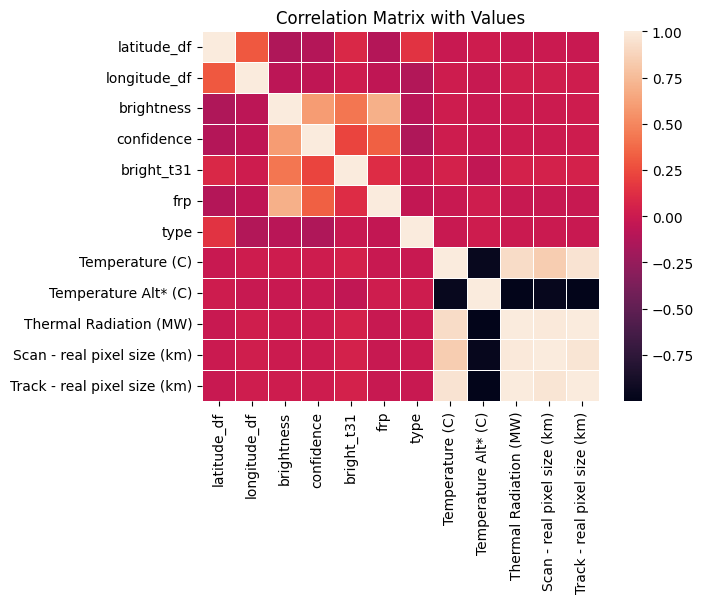

In [10]:
sns.heatmap(correlation_matrix, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with Values')
plt.show()

Tenemos que hay una alta correlacion entre brightness y frp, tambien entre Radiación térmica (MW) y Temperatura (C), la ultima correlacion con valores altos es entre Scan - real pixel size (km) y  Temperatura (C)

In [11]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of samples
num_samples = 1000

# Mean of variables
mean = [350, 10, 350, 25, 0.5]

# Covariance matrix based on the correlation you provided
# You should adjust these values based on the actual correlation you want to represent
covariance_matrix = [
    [100, 50, 80, 70, 0.2],
    [50, 100, 60, 50, 0.15],
    [80, 60, 150, 120, 0.25],
    [70, 50, 120, 100, 0.2],
    [0.2, 0.15, 0.25, 0.2, 0.01]
]

# Generate random features following the multivariate distribution
features = pd.DataFrame(np.random.multivariate_normal(mean, covariance_matrix, size=num_samples),
                         columns=['brightness', 'frp', 'thermal_radiation', 'temperature', 'scan_size'])

# Assign values to the target variable "fire" based on thermal radiation
features['fire'] = np.where(features['thermal_radiation'] > 350, 1, 0)

# View the first few records of the dataset
print(features.head())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features.drop('fire', axis=1), features['fire'], test_size=0.2, random_state=42)

# View the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


   brightness        frp  thermal_radiation  temperature  scan_size  fire
0  342.270525   6.974957         347.288477    19.408191   0.471183     0
1  349.063956  24.456798         349.161724    25.069221   0.555428     0
2  351.683789  10.211739         355.602404    32.956634   0.331642     1
3  351.618688   7.063041         359.428235    34.028702   0.368038     1
4  337.324245  -1.224474         332.455078    13.106871   0.407361     0
Shape of X_train: (800, 5)
Shape of X_test: (200, 5)
Shape of y_train: (800,)
Shape of y_test: (200,)


In [12]:
# Assume 'features' is your DataFrame with the generated and adjusted data as discussed earlier.

# Assign variables X and y
X = features.drop('fire', axis=1)
y = features['fire']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output with sigmoid activation for binary classification problems
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
accuracy = model.evaluate(X_test_scaled, y_test)[1]
print(f'Test set accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
20/20 [==============================] - 1s 12ms/step - loss: 0.6105 - accuracy: 0.7719 - val_loss: 0.5038 - val_accuracy: 0.8938
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4315 - accuracy: 0.9172 - val_loss: 0.3550 - val_accuracy: 0.9000
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.3178 - accuracy: 0.9187 - val_loss: 0.2639 - val_accuracy: 0.9062
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2407 - accuracy: 0.9281 - val_loss: 0.2050 - val_accuracy: 0.9187
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 0.1858 - accuracy: 0.9453 - val_loss: 0.1671 - val_accuracy: 0.9312
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 0.1475 - accuracy: 0.9547 - val_loss: 0.1352 - val_accuracy: 0.9438
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.1213 - accuracy: 0.9594 - val_loss: 0.1199 - val_accuracy: 0.9500
Epoch 8/10
20/20 [=